# SiamMAE

In [1]:
import torch
from mae.models_mae import  mae_vit_base_patch16

In [2]:
from dataset_loader.dataset import get_kinetics_dataset, unnormalize_for_plot, unnormalize

/home/eele/miniconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    
print("Using device =", device)

Using device = cuda


In [4]:
data = get_kinetics_dataset("./dataset/")

Loading dataset from ./dataset/
min_gap: 2, max_gap: 10, temporal_dim: -3, repeated_sampling: 3


In [5]:
print(data.num_videos)

711


In [6]:
BATCH_SIZE = 8

data_loader = torch.utils.data.DataLoader(
    data,
    batch_size=BATCH_SIZE,
)

torch.Size([8, 4, 3, 224, 224])


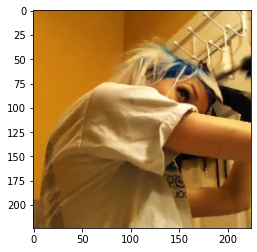

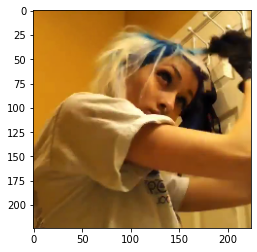

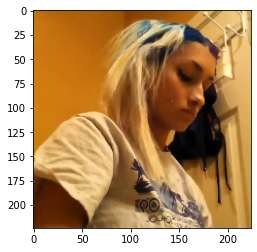

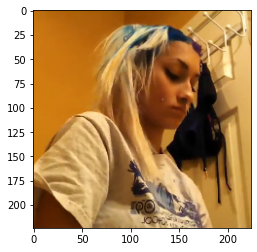

In [7]:
# torch.Size([3, 3, 224, 224])
from dataset_loader.dataset import unnormalize


for batch in data_loader:
    print(batch["video"].shape)
    # torch.Size([8, 4, 3, 224, 224])
    # [BATCH_SIZE x Frames x Channel x Height x Width ]

    import matplotlib.pyplot as plt
    for i in range(batch["video"].shape[1]):
        plt.imshow(unnormalize_for_plot(batch["video"][0][:][i]))
        plt.show()
    break

In [8]:
mae_model = mae_vit_base_patch16().to(device)
mae_model2 = mae_vit_base_patch16().to(device)

In [9]:
# "We use the ViT-S/16 model for most of our experiments as it is similar to ResNet-50 in
# terms of the number of parameters (21M vs 23M) and allows for fair comparisons across different
# self-supervised learning and correspondence learning methods."

In [10]:
# A joint decoder applies vanilla Transformer blocks on the concatenation of full set of tokens from
# both frames. A key downside of this approach is a substantial increase in GPU memory requirement,
# especially when using smaller patch sizes.

In [11]:
class SiamMAE(torch.nn.Module):
    def __init__(self, mae, mae2):
        super().__init__()
        self.mae = mae
        self.mae2 = mae2

    def forward(self, x):
        frame_one = x[:, 0, :, :, :]
        # * Currently we assume that we take the next frame always. 
        # * This could be improved
        frame_rest = x[:, 1, :, :, :]

        frame_one_x, frame_one_mask, frame_one_ids = self.mae.forward_encoder(frame_one, mask_ratio = 0)
        print(f"Frame one shape is {frame_one_x.shape} - Frame one mask shape is {frame_one_mask.shape} - Frame one ids shape is {frame_one_ids.shape}")
        
        frame_rest_x, frame_rest_mask, frame_rest_ids = self.mae2.forward_encoder(frame_rest, mask_ratio = 0.75)
        print(f"Frame Rest X shape is {frame_rest_x.shape} - Frame Rest Mask shape is {frame_rest_mask.shape} - Frame Rest Ids shape is {frame_rest_ids.shape}")
        
        return frame_rest_x
        combine_frames = torch.cat((frame_one, frame_rest), dim=1)

        return self.mae_decoder(combine_frames)
    


In [13]:
first_batch = next(iter(data_loader))
siam = SiamMAE(mae_model,mae_model2).to(device)

frame_rest_x = siam(first_batch["video"].to(device))

Frame one shape is torch.Size([8, 197, 768]) - Frame one mask shape is torch.Size([8, 196]) - Frame one ids shape is torch.Size([8, 196])
Frame Rest X shape is torch.Size([8, 50, 768]) - Frame Rest Mask shape is torch.Size([8, 196]) - Frame Rest Ids shape is torch.Size([8, 196])
